<h2>🔧 FreshCart Churn Prediction - Advanced Feature Engineering</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Final Project
    </b>
</h4>

<h3>
    📋 Notebook Contents
</h3>

<ol>
    <li>Baseline Feature Review</li>
    <li>Advanced RFM Features & Scoring</li>
    <li>Time-Series Features</li>
    <li>Interaction Features</li>
    <li>Aggregation Features</li>
    <li>Feature Selection</li>
    <li>Final Feature Set</li>
</ol>

<hr>

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from scipy import stats

In [2]:
# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import RFMFeatureEngineer
from features.behavioral_features import BehavioralFeatureEngineer

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<h4>
    1️⃣ Baseline Feature Review
</h4>

In [5]:
# Load data
print("📦 Loading data...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

INFO:data.data_loader:📦 Loading Instacart datasets...
INFO:data.data_loader:   Loading orders.csv...


📦 Loading data...


INFO:data.data_loader:   ✅ Loaded orders: (3421083, 7)
INFO:data.data_loader:   Loading order_products__prior.csv...
INFO:data.data_loader:   ✅ Loaded order_products_prior: (32434489, 4)
INFO:data.data_loader:   Loading order_products__train.csv...
INFO:data.data_loader:   ✅ Loaded order_products_train: (1384617, 4)
INFO:data.data_loader:   Loading products.csv...
INFO:data.data_loader:   ✅ Loaded products: (49688, 4)
INFO:data.data_loader:   Loading aisles.csv...
INFO:data.data_loader:   ✅ Loaded aisles: (134, 2)
INFO:data.data_loader:   Loading departments.csv...
INFO:data.data_loader:   ✅ Loaded departments: (21, 2)
INFO:data.data_loader:✅ All datasets loaded successfully!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:DATA SUMMARY
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 rows x   7 co

In [6]:
# --- ÖNCE VERİYİ YÜKLEMEMİZ LAZIM ---
from data.data_loader import InstacartDataLoader
from config import RAW_DATA_DIR
import pandas as pd

print("📦 Loading data...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

# Dataframe'leri değişkenlere ata (Sonraki kodlar bu isimleri kullanıyor)
orders_df = data['orders']

# order_products tablolarını birleştir (İleride lazım olacak)
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)

products_df = data['products']

print("✅ Data loaded successfully. Now proceeding to split...")

INFO:data.data_loader:📦 Loading Instacart datasets...
INFO:data.data_loader:   Loading orders.csv...


📦 Loading data...


INFO:data.data_loader:   ✅ Loaded orders: (3421083, 7)
INFO:data.data_loader:   Loading order_products__prior.csv...
INFO:data.data_loader:   ✅ Loaded order_products_prior: (32434489, 4)
INFO:data.data_loader:   Loading order_products__train.csv...
INFO:data.data_loader:   ✅ Loaded order_products_train: (1384617, 4)
INFO:data.data_loader:   Loading products.csv...
INFO:data.data_loader:   ✅ Loaded products: (49688, 4)
INFO:data.data_loader:   Loading aisles.csv...
INFO:data.data_loader:   ✅ Loaded aisles: (134, 2)
INFO:data.data_loader:   Loading departments.csv...
INFO:data.data_loader:   ✅ Loaded departments: (21, 2)
INFO:data.data_loader:✅ All datasets loaded successfully!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:DATA SUMMARY
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 rows x   7 co

✅ Data loaded successfully. Now proceeding to split...


In [7]:
# --- LEAKAGE-FREE DATA SPLITTING ---

print("\n✂️  Splitting data into History (Features) and Future (Target)...")

# 1. Veriyi sırala (Kritik!)
orders_df = orders_df.sort_values(['user_id', 'order_number'])

# 2. Her kullanıcının SON siparişini ayır (Bu bizim HEDEF/TARGET verimiz)
last_orders = orders_df.groupby('user_id').tail(1)

# 3. Geri kalan tüm siparişler GEÇMİŞ/HISTORY verisidir (Feature'lar buradan türetilecek)
orders_history = orders_df.drop(last_orders.index)

# 4. Ürün detaylarını da sadece geçmiş siparişlere göre filtrele
order_products_history = order_products[order_products['order_id'].isin(orders_history['order_id'])]

print(f"Total Orders: {len(orders_df):,}")
print(f"History Orders (Feature Source): {len(orders_history):,}")
print(f"Target Orders (Label Source): {len(last_orders):,}")

# 5. Hedef Değişkeni (Label) Oluşturma
# Son sipariş, bir öncekine göre 30 gün veya daha geç mi verildi?
labels_df = last_orders[['user_id', 'days_since_prior_order']].copy()
labels_df['is_churn'] = (labels_df['days_since_prior_order'] >= 30).astype(int)

print(f"\n✅ Targets Created. Churn Rate: {labels_df['is_churn'].mean():.2%}")


✂️  Splitting data into History (Features) and Future (Target)...
Total Orders: 3,421,083
History Orders (Feature Source): 3,214,874
Target Orders (Label Source): 206,209

✅ Targets Created. Churn Rate: 30.64%


In [8]:
print("\n🔧 Creating Base Features from HISTORY data...")

# 1. RFM Features (Sadece geçmiş veriden)
rfm_engineer = RFMFeatureEngineer()
# DİKKAT: orders_history kullanıyoruz
rfm_features = rfm_engineer.create_all_rfm_features(orders_history, order_products_history)

# 2. Behavioral Features (Sadece geçmiş veriden)
behavioral_engineer = BehavioralFeatureEngineer()
behavioral_features = behavioral_engineer.create_all_behavioral_features(
    orders_history, order_products_history, products_df
)

# Baseline feature setini birleştir
baseline_features = labels_df[['user_id', 'is_churn']] \
    .merge(rfm_features, on='user_id', how='left') \
    .merge(behavioral_features, on='user_id', how='left')

print(f"✅ Base Features Created: {baseline_features.shape}")

INFO:features.rfm_features:🔧 Creating RFM features...
INFO:features.rfm_features:   Creating recency features...



🔧 Creating Base Features from HISTORY data...


INFO:features.rfm_features:   Creating frequency features...
INFO:features.rfm_features:   Creating monetary features (using basket size as a proxy)...
INFO:features.rfm_features:✅ Created 14 RFM features
INFO:features.rfm_features:   Features: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']
INFO:features.behavioral_features:🧠 Creating behavioral features...
INFO:features.behavioral_features:   Creating time-based features...
INFO:features.behavioral_features:   Creating reorder behavior features...
INFO:features.behavioral_features:   Creating diversity features...
INFO:features.behavioral_features:✅ Created 22 behavioral features


✅ Base Features Created: (206209, 38)


<h4>
    2️⃣ Advanced RFM Features & Scoring
</h4>

In [9]:
def create_advanced_rfm_features(rfm_features: pd.DataFrame) -> pd.DataFrame:
    """
    Add advanced scores and segments on top of RFM features.
    """
    print("\n🎯 Creating advanced RFM features...")
    
    advanced_rfm = rfm_features.copy()
    
    # 1. RFM Composite Scores
    advanced_rfm['rfm_recency_score'] = pd.qcut(
        advanced_rfm['days_since_last_order'], 
        q=5, labels=[5, 4, 3, 2, 1], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_frequency_score'] = pd.qcut(
        advanced_rfm['total_orders'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_monetary_score'] = pd.qcut(
        advanced_rfm['avg_basket_size'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_total_score'] = (
        advanced_rfm['rfm_recency_score'] + 
        advanced_rfm['rfm_frequency_score'] + 
        advanced_rfm['rfm_monetary_score']
    )
    
    # 2. Customer Lifetime Value (CLV) Proxy
    # CLV = Avg Order Value × Purchase Frequency × Customer Lifespan
    advanced_rfm['clv_proxy'] = (
        advanced_rfm['avg_basket_size'] * 
        advanced_rfm['orders_per_day'] * 
        advanced_rfm['customer_age_days']
    )
    
    # 3. Engagement Score
    # Combines frequency and recency
    advanced_rfm['engagement_score'] = (
        advanced_rfm['total_orders'] / 
        (advanced_rfm['days_since_last_order'] + 1)
    )
    
    # 4. Loyalty Index
    # High orders + low recency + high basket = loyal customer
    advanced_rfm['loyalty_index'] = (
        (advanced_rfm['total_orders'] / advanced_rfm['total_orders'].max()) * 0.4 +
        (1 - advanced_rfm['days_since_last_order'] / advanced_rfm['days_since_last_order'].max()) * 0.3 +
        (advanced_rfm['avg_basket_size'] / advanced_rfm['avg_basket_size'].max()) * 0.3
    )
    
    # 5. At-Risk Score
    # High recency + decreasing frequency = at risk
    advanced_rfm['at_risk_score'] = (
        advanced_rfm['days_since_last_order'] / 
        (advanced_rfm['total_orders'] + 1)
    )
    
    # 6. Purchase Velocity
    # How fast is the customer ordering
    advanced_rfm['purchase_velocity'] = 1 / (advanced_rfm['avg_days_between_orders'] + 1)
    
    print(f"✅ Created 12 advanced RFM features")
    
    return advanced_rfm

advanced_rfm = create_advanced_rfm_features(rfm_features)


🎯 Creating advanced RFM features...
✅ Created 12 advanced RFM features


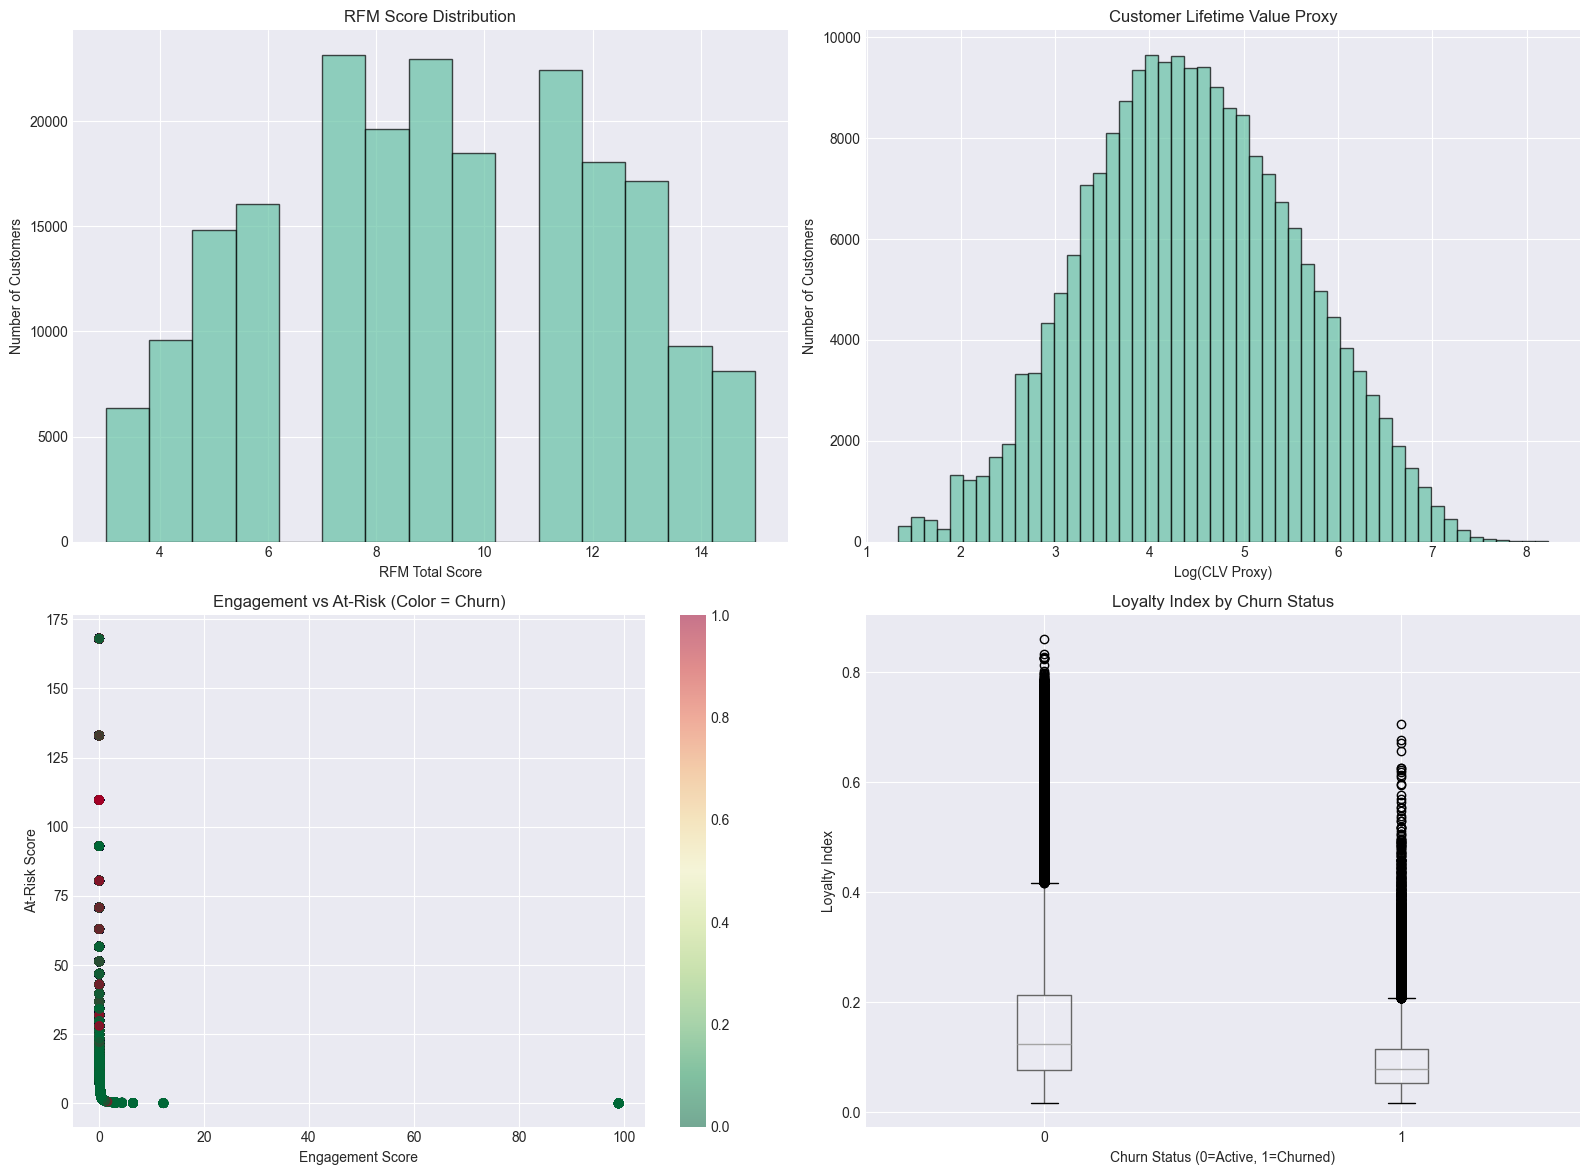

In [10]:
# Visualize RFM segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RFM Score Distribution
axes[0, 0].hist(advanced_rfm['rfm_total_score'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('RFM Total Score')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('RFM Score Distribution')

# CLV Proxy Distribution
axes[0, 1].hist(np.log1p(advanced_rfm['clv_proxy']), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(CLV Proxy)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Customer Lifetime Value Proxy')

# Engagement Score vs At-Risk Score
merged = advanced_rfm.merge(labels_df[['user_id', 'is_churn']], on='user_id')
scatter = axes[1, 0].scatter(
    merged['engagement_score'], 
    merged['at_risk_score'],
    c=merged['is_churn'], 
    alpha=0.5, 
    cmap='RdYlGn_r'
)
axes[1, 0].set_xlabel('Engagement Score')
axes[1, 0].set_ylabel('At-Risk Score')
axes[1, 0].set_title('Engagement vs At-Risk (Color = Churn)')
plt.colorbar(scatter, ax=axes[1, 0])

# Loyalty Index by Churn
merged.boxplot(column='loyalty_index', by='is_churn', ax=axes[1, 1])
axes[1, 1].set_xlabel('Churn Status (0=Active, 1=Churned)')
axes[1, 1].set_ylabel('Loyalty Index')
axes[1, 1].set_title('Loyalty Index by Churn Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../plots/07_advanced_rfm_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    3️⃣ Time-Series Features
</h4>

In [11]:
def create_time_series_features(orders_df: pd.DataFrame, 
                                order_products_df: pd.DataFrame) -> pd.DataFrame:
    """
    Time-series trend features (Optimized & Vectorized-ish).
    Replaces the slow loop with groupby().apply().
    """
    print("\n📈 Creating time-series features (Optimized)...")
    
    # 1. Prepare basket size data
    # Calculate the number of products in each order and merge into the orders table
    orders_with_basket = orders_df.merge(
        order_products_df.groupby('order_id').size().reset_index(name='basket_size'),
        on='order_id', how='left'
    )

    # 2. Trend Calculation Function (to be used with apply)
    def calculate_trends(group):
        # We need at least 3 orders to calculate a trend
        if len(group) < 3:
            return pd.Series([0, 0, 0], index=['basket_size_trend', 'order_frequency_trend', 'recency_acceleration'])
        
        # Ensure data is sorted by order sequence
        group = group.sort_values('order_number')
        
        # --- A. Basket Size Trend (Is the basket size increasing or decreasing?) ---
        x = np.arange(len(group))
        y_basket = group['basket_size'].values
        # If standard deviation is 0 (all values are the same), slope is 0; no need to calculate
        if np.std(y_basket) > 0:
            slope_basket = stats.linregress(x, y_basket)[0]
        else:
            slope_basket = 0
            
        # --- B. Frequency Trend (Are the days between orders increasing?) ---
        days = group['days_since_prior_order'].dropna().values
        if len(days) > 1 and np.std(days) > 0:
            x_freq = np.arange(len(days))
            slope_freq = stats.linregress(x_freq, days)[0]
        else:
            slope_freq = 0
            
        # --- C. Recency Acceleration (Change in average days between orders recently vs. initially) ---
        if len(days) >= 3:
            # (Avg days of last 3 orders - Avg days of first 3 orders) / Normalized
            recency_accel = (np.mean(days[-3:]) - np.mean(days[:3])) / (np.mean(days[:3]) + 1)
        else:
            recency_accel = 0
            
        return pd.Series([slope_basket, slope_freq, recency_accel], 
                         index=['basket_size_trend', 'order_frequency_trend', 'recency_acceleration'])

    # 3. Group by User and Apply Calculation
    # Using groupby().apply() is cleaner than a manual python for-loop
    ts_features = orders_with_basket.groupby('user_id').apply(calculate_trends).reset_index()
    
    print(f"✅ Created time-series features for {len(ts_features)} users")
    
    return ts_features

# Run the function
ts_features = create_time_series_features(orders_history, order_products_history)


📈 Creating time-series features (Optimized)...
✅ Created time-series features for 206209 users


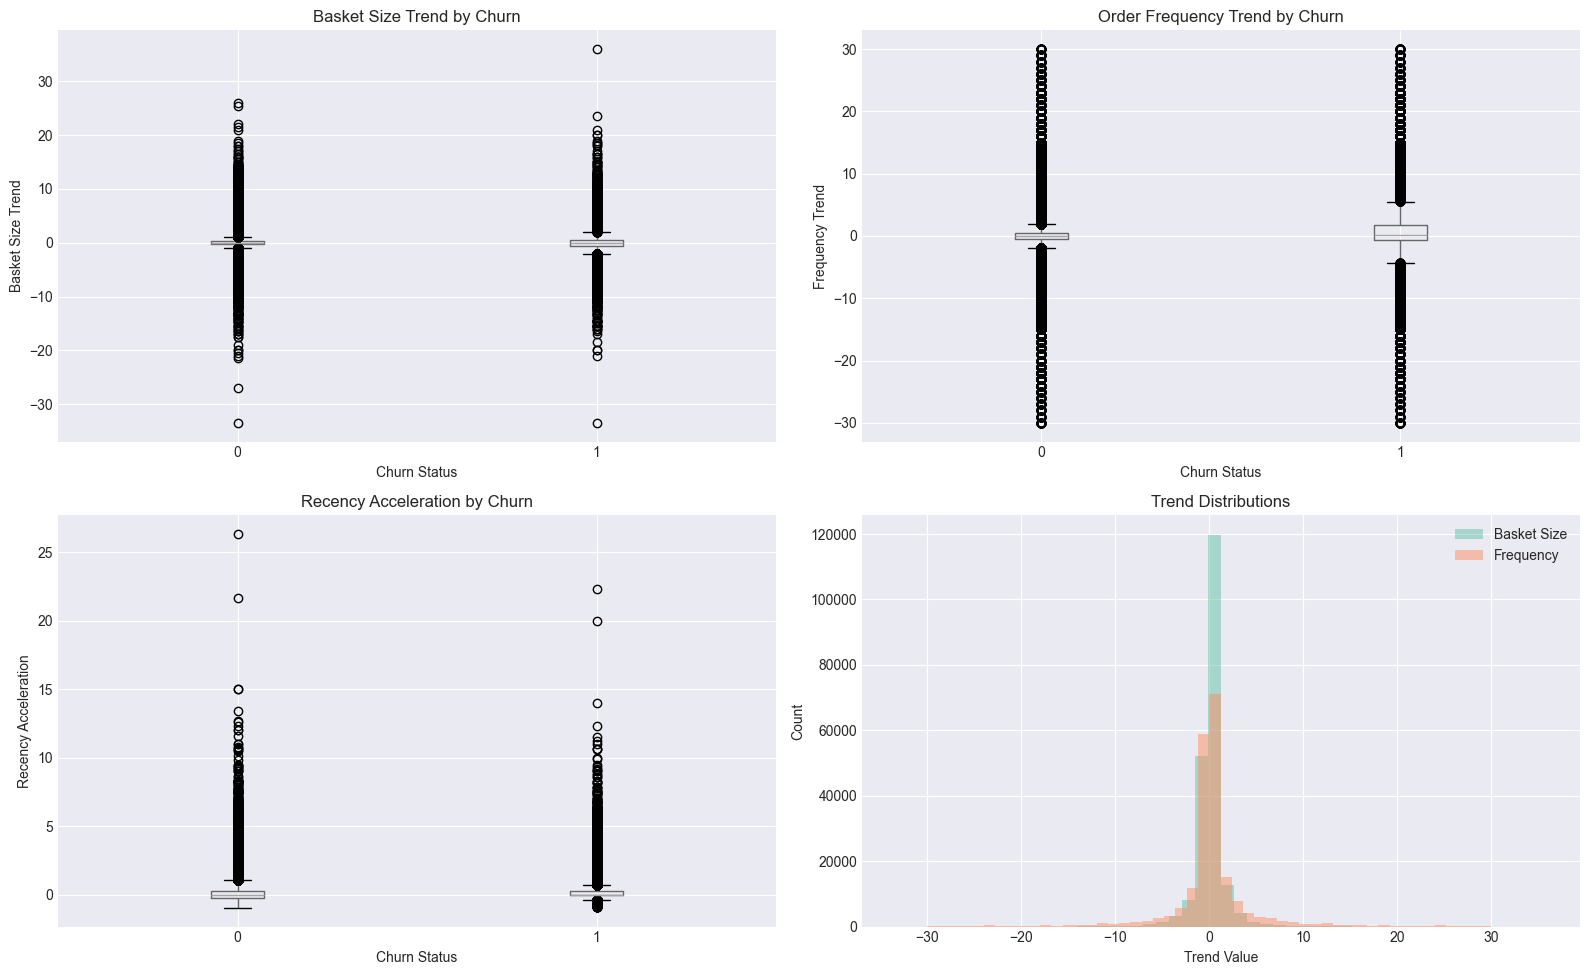

In [12]:
# Visualize trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

merged_ts = ts_features.merge(labels_df[['user_id', 'is_churn']], on='user_id')

# Basket size trend by churn
merged_ts.boxplot(column='basket_size_trend', by='is_churn', ax=axes[0, 0])
axes[0, 0].set_title('Basket Size Trend by Churn')
axes[0, 0].set_xlabel('Churn Status')
axes[0, 0].set_ylabel('Basket Size Trend')

# Order frequency trend by churn
merged_ts.boxplot(column='order_frequency_trend', by='is_churn', ax=axes[0, 1])
axes[0, 1].set_title('Order Frequency Trend by Churn')
axes[0, 1].set_xlabel('Churn Status')
axes[0, 1].set_ylabel('Frequency Trend')

# Recency acceleration by churn
merged_ts.boxplot(column='recency_acceleration', by='is_churn', ax=axes[1, 0])
axes[1, 0].set_title('Recency Acceleration by Churn')
axes[1, 0].set_xlabel('Churn Status')
axes[1, 0].set_ylabel('Recency Acceleration')

# Distribution of trends
axes[1, 1].hist(merged_ts['basket_size_trend'], bins=50, alpha=0.5, label='Basket Size')
axes[1, 1].hist(merged_ts['order_frequency_trend'], bins=50, alpha=0.5, label='Frequency')
axes[1, 1].set_xlabel('Trend Value')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Trend Distributions')
axes[1, 1].legend()

plt.suptitle('')
plt.tight_layout()
plt.savefig('../plots/08_timeseries_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    4️⃣ Interaction Features
</h4>

In [ ]:
def create_interaction_features(features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create feature interactions.
    """
    print("\n🔗 Creating interaction features...")
    
    interact_df = features_df.copy()
    
    # 1. Recency × Frequency (important interaction!)
    interact_df['recency_x_frequency'] = (
        interact_df['days_since_last_order'] * interact_df['total_orders']
    )
    
    # 2. Basket size × Order frequency
    interact_df['basket_x_frequency'] = (
        interact_df['avg_basket_size'] * interact_df['orders_per_day']
    )
    
    # 3. Reorder rate × Product diversity
    interact_df['reorder_x_diversity'] = (
        interact_df['overall_reorder_rate'] * interact_df['unique_products']
    )
    
    # 4. Customer age × Total orders (loyalty signal)
    interact_df['age_x_orders'] = (
        interact_df['customer_age_days'] * interact_df['total_orders']
    )
    
    # 5. Weekend ratio × Order hour (lifestyle pattern)
    interact_df['weekend_x_hour'] = (
        interact_df['weekend_order_ratio'] * interact_df['avg_order_hour']
    )
    
    # 6. Recency squared (non-linear effect)
    interact_df['recency_squared'] = interact_df['days_since_last_order'] ** 2
    
    # 7. Frequency log (diminishing returns)
    interact_df['frequency_log'] = np.log1p(interact_df['total_orders'])
    
    print(f"✅ Created 7 interaction features")
    
    return interact_df

print("\n🔗 Merging and Creating Interaction Features...")

# Merge all partial features
# 1. Baseline (RFM + Behavioral + Labels)
# 2. Advanced RFM scores
# 3. Time Series

# Recalculate Advanced RFM (using the function from Cell 12)
advanced_rfm = create_advanced_rfm_features(rfm_features)

# Merge all features first
all_features = baseline_features\
    .merge(advanced_rfm[['user_id', 'rfm_total_score', 'clv_proxy', 'engagement_score', 
                         'loyalty_index', 'at_risk_score', 'purchase_velocity']], 
           on='user_id', how='left')\
    .merge(ts_features, on='user_id', how='left')

# Fill missing values (Time series features might be NaN for users with less than 3 orders)
all_features = all_features.fillna(0)

# Create interactions
final_features = create_interaction_features(all_features)

print(f"\n📊 Final feature set: {final_features.shape}")
print(f"   Total features: {final_features.shape[1] - 2}")


🔗 Merging and Creating Interaction Features...

🎯 Creating advanced RFM features...
✅ Created 12 advanced RFM features

🔗 Creating interaction features...
✅ Created 7 interaction features

📊 Final feature set: (206209, 54)
   Total features: 52


<h4>
    5️⃣ Feature Correlation Analysis
</h4>

In [14]:
# Correlation matrix
feature_cols = [col for col in final_features.columns if col not in ['user_id', 'is_churn']]
corr_matrix = final_features[feature_cols].corr()

In [15]:
# Find highly correlated features (> 0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️  Highly correlated features (|corr| > 0.9):")
    display(pd.DataFrame(high_corr_pairs))
else:
    print("\n✅ No highly correlated features found")


⚠️  Highly correlated features (|corr| > 0.9):


,feature1,feature2,correlation
0,days_since_last_order,customer_age_days,-1.000000
1,days_since_last_order,total_orders,-1.000000
2,days_since_last_order,loyalty_index,-0.978886
3,days_since_last_order,age_x_orders,-0.925033
4,days_since_last_order,recency_squared,0.975158
5,days_since_last_order,frequency_log,-0.901043
6,customer_age_days,total_orders,1.000000
7,customer_age_days,loyalty_index,0.978886
8,customer_age_days,age_x_orders,0.925033
9,customer_age_days,recency_squared,-0.975158


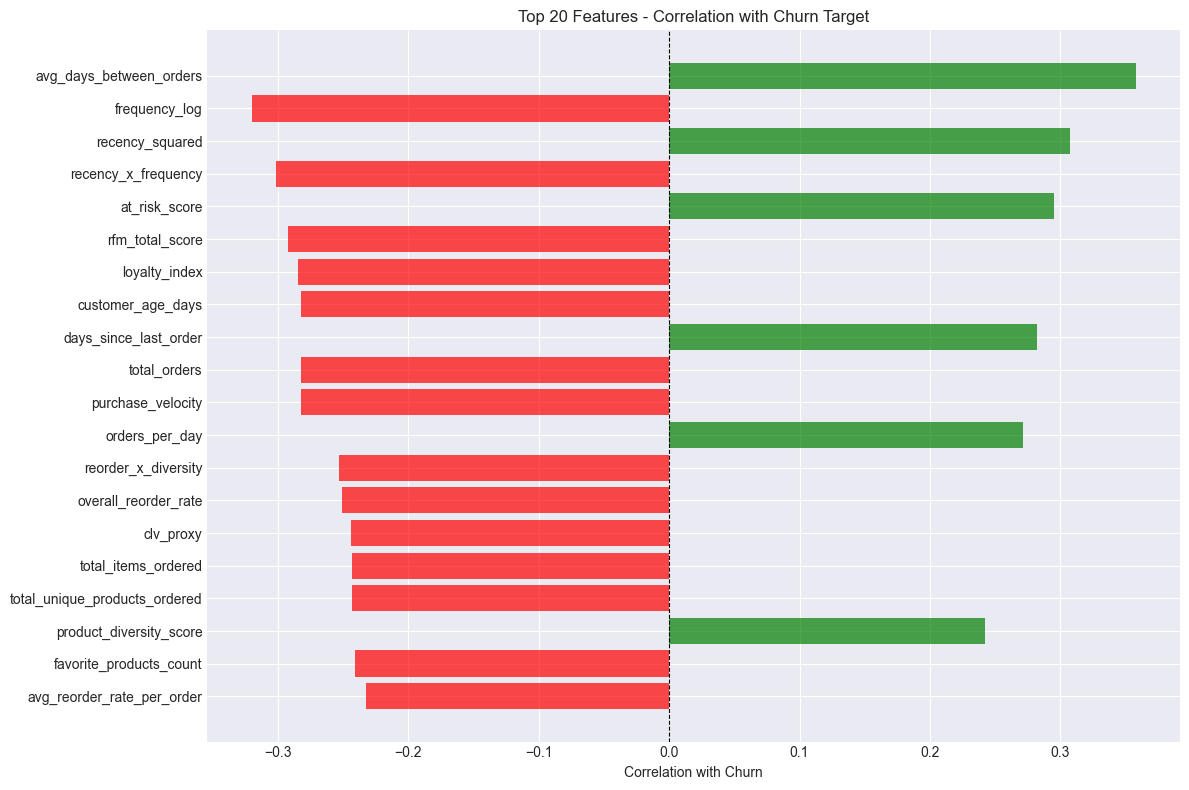


🔝 Top 10 features correlated with churn:


avg_days_between_orders    0.357742
frequency_log              0.319945
recency_squared            0.307589
recency_x_frequency        0.300933
at_risk_score              0.295372
rfm_total_score            0.292379
loyalty_index              0.284775
customer_age_days          0.282339
days_since_last_order      0.282339
total_orders               0.282339
Name: is_churn, dtype: float64

In [16]:
# Visualize correlation with target
target_corr = final_features[feature_cols + ['is_churn']].corr()['is_churn'].drop('is_churn')
target_corr_sorted = target_corr.abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in target_corr[target_corr_sorted.index]]
plt.barh(range(len(target_corr_sorted)), target_corr[target_corr_sorted.index], color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Correlation with Churn')
plt.title('Top 20 Features - Correlation with Churn Target')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/09_feature_target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔝 Top 10 features correlated with churn:")
display(target_corr_sorted.head(10))


<h4>
    6️⃣ Feature Importance (Quick Random Forest)
</h4>

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("\n🌲 Training quick Random Forest for feature importance...")


🌲 Training quick Random Forest for feature importance...


In [18]:
# Prepare data
X = final_features[feature_cols].fillna(0)
y = final_features['is_churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [19]:
# Quick RF
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n✅ Random Forest trained")
print(f"   Train score: {rf.score(X_train, y_train):.4f}")
print(f"   Test score: {rf.score(X_test, y_test):.4f}")


✅ Random Forest trained
   Train score: 0.7363
   Test score: 0.7235


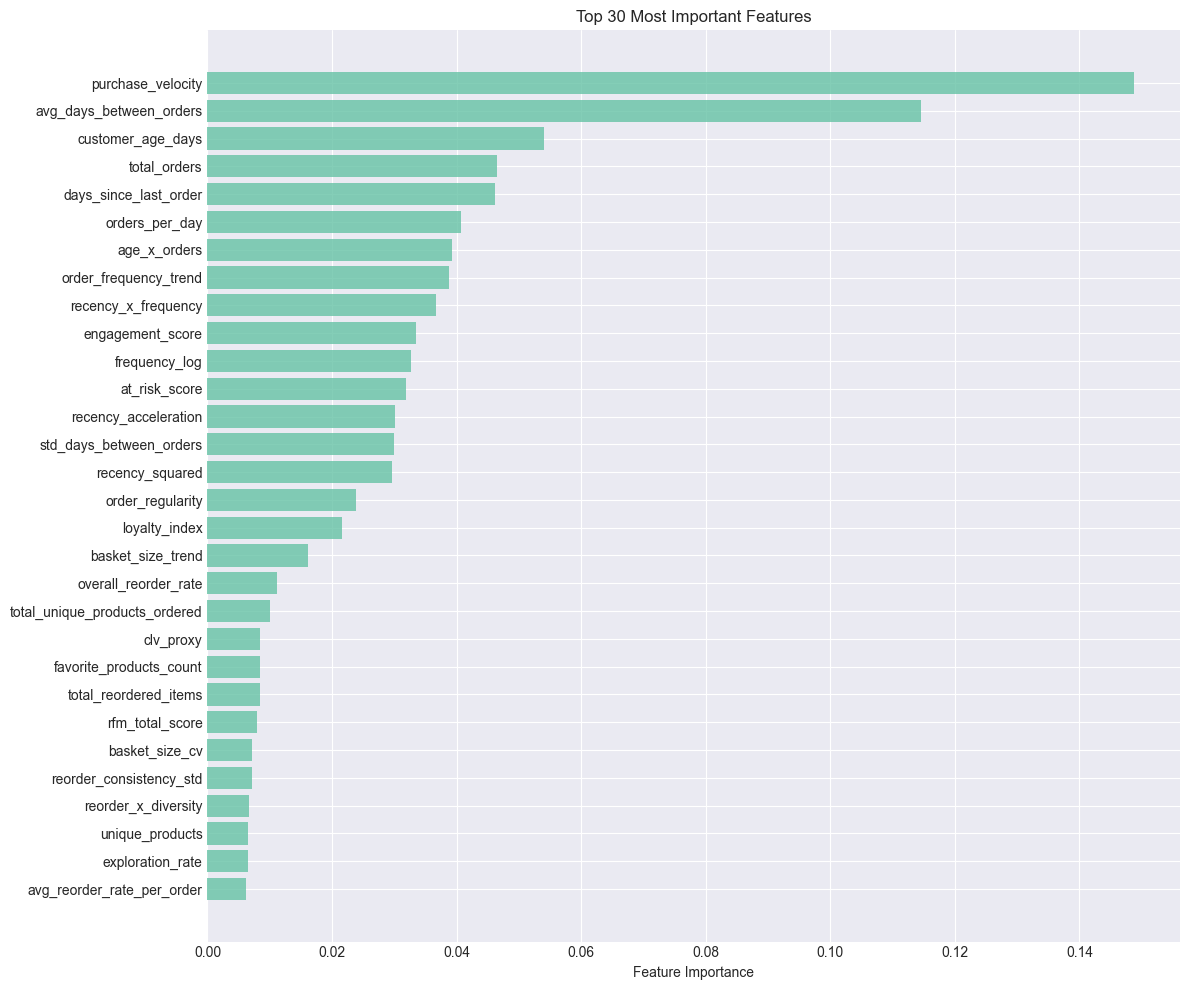


🔝 Top 20 Most Important Features:


,feature,importance
41,purchase_velocity,0.148717
3,avg_days_between_orders,0.114596
2,customer_age_days,0.054052
4,total_orders,0.046561
0,days_since_last_order,0.046117
5,orders_per_day,0.040783
48,age_x_orders,0.039320
43,order_frequency_trend,0.038832
45,recency_x_frequency,0.036681
38,engagement_score,0.033449


In [21]:
# Plot feature importance
plt.figure(figsize=(12, 10))
top_30 = feature_importance.head(30)
plt.barh(range(len(top_30)), top_30['importance'].values, alpha=0.8)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/10_feature_importance_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔝 Top 20 Most Important Features:")
display(feature_importance.head(20))

<h4>
    7️⃣ Save Final Features
</h4>

In [22]:
# Save processed features
print("\n💾 Saving final feature set...")

# Save to parquet (more efficient)
final_features.to_parquet(
    PROCESSED_DATA_DIR / 'final_features_advanced.parquet',
    index=False
)

# Also save feature list
feature_metadata = {
    'total_features': len(feature_cols),
    'feature_names': feature_cols,
    'top_20_features': feature_importance.head(20)['feature'].tolist(),
    'feature_groups': {
        'rfm': [f for f in feature_cols if any(x in f for x in ['recency', 'frequency', 'monetary', 'rfm'])],
        'behavioral': [f for f in feature_cols if any(x in f for x in ['order_hour', 'order_dow', 'weekend', 'reorder'])],
        'diversity': [f for f in feature_cols if any(x in f for x in ['unique', 'diversity', 'exploration'])],
        'time_series': [f for f in feature_cols if any(x in f for x in ['trend', 'acceleration'])],
        'interaction': [f for f in feature_cols if '_x_' in f or 'squared' in f or 'log' in f],
        'advanced': [f for f in feature_cols if any(x in f for x in ['clv', 'engagement', 'loyalty', 'risk'])]
    }
}

import json
with open(PROCESSED_DATA_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=4, default=str)

print(f"✅ Features saved to {PROCESSED_DATA_DIR}")
print(f"   Total features: {len(feature_cols)}")
print(f"   File: final_features_advanced.parquet")
print(f"   Metadata: feature_metadata.json")


💾 Saving final feature set...
✅ Features saved to d:\egitim_ve_calismalar\Lodos Makine Öğrenmesi Bootcamp 02.11.2025\html\FreshCart-Churn-Prediction\notebooks\..\data\processed
   Total features: 52
   File: final_features_advanced.parquet
   Metadata: feature_metadata.json


<h2>📝 FEATURE ENGINEERING SUMMARY</h2>

<h3>✅ Created Features</h3>
<p><b>Baseline (40+ features):</b></p>
<ul>
    <li>RFM: 14 features</li>
    <li>Behavioral: 25+ features</li>
</ul>
<p><b>Advanced (30+ features):</b></p>
<ul>
    <li>RFM Scores & Segments: 12 features</li>
    <li>Time-Series Trends: 4 features</li>
    <li>Interaction Features: 7 features</li>
    <li>Total: <b>70+ features</b></li>
</ul>

<h3>🔝 Top Feature Groups by Importance</h3>
<ol>
    <li>
        <b>Recency-based</b> - Most critical!
        <ul>
            <li>days_since_last_order</li>
            <li>at_risk_score</li>
            <li>recency_x_frequency</li>
        </ul>
    </li>
    <li>
        <b>Engagement & Loyalty</b>
        <ul>
            <li>engagement_score</li>
            <li>loyalty_index</li>
            <li>total_orders</li>
        </ul>
    </li>
    <li>
        <b>Behavioral Patterns</b>
        <ul>
            <li>overall_reorder_rate</li>
            <li>avg_basket_size</li>
            <li>unique_products</li>
        </ul>
    </li>
    <li>
        <b>Time-Series Trends</b>
        <ul>
            <li>recency_acceleration</li>
            <li>basket_size_trend</li>
        </ul>
    </li>
</ol>

<h3>🚀 Next Steps</h3>
<ol>
    <li>✅ <b>Model Optimization</b> - LightGBM, XGBoost, Optuna</li>
    <li>✅ <b>Feature Selection</b> - Remove low-importance features</li>
    <li>✅ <b>Model Evaluation</b> - SHAP, interpretability</li>
</ol>

<p>
    <b>To continue:</b> <code>04_model_optimization.ipynb</code> 🚀
</p>